# 7.4 Deep Learning methods for object detection

In the previous notebooks we have developed different **Machine Learning** (ML) algorithms for classifying images containing objects according to high-level features (shape, color, texture, etc.). In a nutshell, these methods use a number of representatitive images to train a classifier, which is composed by a set of parameters. Once trained, the model can be used to infer the category of objects appearing in new images not seen before.

As you may now, in the recent years there is an explosion of **Deep Learning** (DL) techniques that are achieving a high performance in different tasks. Indeed, DL models are a subgroup of ML with the peculiarity of having thousands, millions of parameters. This is achieved by using multiple layers, each one consisting of a given number of parameters, hence the *deep* of DL. 

The choice of ML or DL techniques strongly depend on the application at hand. On the one hand, if there is available a large amount of data to train the model and the target platform where the model will run is powerful enough, then DL techniques are a good option. On the other hand, when data or computational resources' constrains exist, ML methods stands out. Moreover, while ML works with explainable high-level features and processes, DL employs low-level features and are considered black boxes with an input (e.g. an image) and an ouput (e.g. a set of detected objects).

As commented, untill now we have been working with ML models. Let's take a look at DL ones!

## Problem context - Object detection for mobile robots

This time we will focus on mobile robots operaing in human-centered environments, for example houses. In order to provide services, a mobile robot must be able to understand its surroundings, including the elements in its workspace. For that object detection is a critital task since it permits the robot to locate objects that can be useful in its duties. Fig 1 provides some examples of objects detected in images coming from a comera mounted on a mobile robot:

<center><img src="./images/dnn/examples_from_robot_at_home.PNG"><br /><i>Figure 1. Images processed by a DL model with annotations about detected objects.</i></center>$\\[5pt]$

Fusing these detections with additional information like the robot pose within the workspace and the relative pose of the camera w.r.t., the objects can be localized in said workspace. For example, Fig. 2 shows the reconstruction of two houses where the robot has detected and placed a number of objects.

<center><img src="./images/dnn/workspace_reconstructions.jpg"><br /><i>Fig 2. Reconstructions of real houses built by a mobile robot.</i></center>$\\[5pt]$


In [81]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.figsize"] = (15.0, 10.0)

## 7.4.1 Preparing the DL model

The task of training a DL model is highly time and resources consuming, typically demanding a cluster of GPUs and huge datasets. Luckily for us, there is a bunch of already trained models freely available that we can use. And what is more, our lovely OpenCV incorporates the **DNN module** (Deep Neural Network), with permits us to run **DL inference**, that is, to feed a network with an image and get the results of its processing. This is quite interesting since we don't need to install other heavy frameworks like Tensorflow, Pytorch, Caffe or Keras often used to deal with these models. Moreover, it's not necessary to have a powerful GPU to make inference since OpenCV DNN is highly optimized to run in CPU. Good news everywhere!

Since our problem is object detection, we will make use of a network trained for that aim. Concretely wee need two resources:
- a file containing the configuration of the model to be used, and
- another file with the weights (parameters) of said network.

Depending on the dataset used to train the network, the categories that it would be able to detect differ. In this notebook we are going to employ a popular network trained with data from [Micrososf COCO](https://cocodataset.org/#home). This is the most used dataset for dealing with object detection related-tasks and considers 80 different categories:

<center><img src="./images/dnn/COCO_categories.PNG"><br /><i>Figure 3. Object categories considered in the COCO dataset. [Source: COCO webpage]</i></center>$\\[5pt]$

The following figure shows an example of an image from COCO, which also includes annotations about the objects that belong to one of the said categories:

<center><img src="./images/dnn/COCO_kitchen_example.PNG"><br /><i>Figure 4. And image of a kitchen from COCO with annotation about the regions belonging to one of the considered categories. [Source: COCO webpage]</i></center>$\\[5pt]$

The COCO dataset has a very nice webpage with many resources, including an explorer where you can see examples like the previous one. We encorage you to take a look at it! Having choosen the network and knowing the dataset it was trained with, its time to load the needed information.

Let's start by loading a file containing the names of the categories from COCO. This is useful since the network will provide the detected objects as numbers related to the indices that the categories has in this file. The following code reads this file and also builds a numpy array that assigns to each category a random color (used for results visualization).

In [82]:
# load the COCO class names
with open('./data/object_detection_classes_coco.txt', 'r') as f:
    class_names = f.read().split('\n')
    
# get a different color array for each of the classes
COLORS = np.random.uniform(0, 255, size=(len(class_names), 3))
type(COLORS)

numpy.ndarray

### **<span style="color:green"><b><i>ASSIGNMENT 1: Exploring categories</i></b></span>**

Let's explore a bit the loaded information. Write the needed code to print the categories appearing from index 40 to index 60 with the format shown in the expected output. You can also try other ranges!

In [83]:
# Assignment 1
for index in range(40, 61):
    print(f'[{index:^4}]  {class_names[index]}')

[ 40 ]  skateboard
[ 41 ]  surfboard
[ 42 ]  tennis racket
[ 43 ]  bottle
[ 44 ]  plate
[ 45 ]  wine glass
[ 46 ]  cup
[ 47 ]  fork
[ 48 ]  knife
[ 49 ]  spoon
[ 50 ]  bowl
[ 51 ]  banana
[ 52 ]  apple
[ 53 ]  sandwich
[ 54 ]  orange
[ 55 ]  broccoli
[ 56 ]  carrot
[ 57 ]  hot dog
[ 58 ]  pizza
[ 59 ]  donut
[ 60 ]  cake


<font color='blue'>**Expected output  </font>**

```
[ 40 ]  skateboard
[ 41 ]  surfboard
[ 42 ]  tennis racket
[ 43 ]  bottle
[ 44 ]  plate
[ 45 ]  wine glass
[ 46 ]  cup
[ 47 ]  fork
[ 48 ]  knife
[ 49 ]  spoon
[ 50 ]  bowl
[ 51 ]  banana
[ 52 ]  apple
[ 53 ]  sandwich
[ 54 ]  orange
[ 55 ]  broccoli
[ 56 ]  carrot
[ 57 ]  hot dog
[ 58 ]  pizza
[ 59 ]  donut
[ 60 ]  cake
```

Once the dataset-related information is loaded, let's do the same with the network configuration and its file of weights. We are going to give a try to SSD Mobile net, but this is just one of the possibilities supported by OpenCV DNN. [Here you can find a list](https://github.com/opencv/opencv/wiki/Deep-Learning-in-OpenCV) with all the networks that have been tested by the OpenCV community. If you want to try another one, [this file contains](https://github.com/opencv/opencv_extra/blob/master/testdata/dnn/download_models.py) the url to download the models' weights, while [this repository](https://github.com/opencv/opencv_extra/tree/4.x/testdata/dnn) provides the networks' configuration files.

SSD comes from Single Shot MultiBox Detector, and it is a popular network presented at the popular European Conference on Computer Vision (ECCV) in 2016<sup>[[1]](#cite1)</sup>. This network consists of two parts:
- A backbone (VGG-16 in the image, but in this case MobileNet is employed) used to extract feature maps from the image and a number of extra feature layers to detect objects at different scales, and
- a number of convolutional layers that carry out the object detections (shown over the lines with the prefix *Classifier*).

The network architecture is depicted in Fig. 5.

<center><img src="./images/dnn/ssd_network_architecture.PNG"><br /><i>Figure 5. Architecture of the SSD network [Source SSD paper]. </i></center>$\\[5pt]$

Let's load this model.

In [84]:
# load the DNN model
model = cv2.dnn.readNet(model='./data/frozen_inference_graph.pb',  
                        config='./data/ssd_mobilenet_v2_coco_2018_03_29.pbtxt',framework='TensorFlow')

## 7.4.2 Doing inference and showing results

The following code loads an image from file, gets its height and width, and set it as input to the model. 

In [85]:
# Read the image from disk
image = cv2.imread('./images/dnn/kitchen_2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_height, image_width, _ = image.shape
# Create blob from image
blob = cv2.dnn.blobFromImage(image=image, size=(300, 300), mean=(104, 117, 123), swapRB=False)
# Set the blob to the model
model.setInput(blob)

Once the information related to the dataset and the network are loaded, as well as an image to be processed, we can perform inference by just calling the ```forward()``` function.

In [86]:
# Forward pass through the model to carry out the detection
output = model.forward()

### **<span style="color:green"><b><i>ASSIGNMENT 2: Showing the results</i></b></span>**

The network output is a set of predictions consisting of object categories, scores and bounding boxes, concretely:
```prediction=[not_used,category,score,bbox_x_ul,bbox_y_ul,bbox_x_br,bbox_y_br]```

For example, the next output:

```[ 0.         52.          0.9821959   0.3924626   0.60919476  0.85021377  0.9348804 ]```

says that it has been detected an apple with a very high score (it ranges from 0 to 1) with a bounding box with the upper left corner at position $[x_{ul},y_{ul}]=[0.3924626 \times img\_width,0.609194 \times img\_height]$ and with the bottom right corner at position $[x_{br},y_{br}]=[0.850213\times img\_width,0.93488\times img\_height]$.

You are tasked to:
- Get the confidence (score) value from the ```detection``` vector, and set a threshold so only detections with a confidence value higher than it are shown (try different values until you get a result similar to the one shown in Fig. 6),
- get the boundig boxes positions and sizes as commented before,
- show the rectangles representing the bounding boxes, and
- build the ```text``` string containing the class names and confidence values as shown in Fig. 6.

<center><img src="./images/dnn/example_of_results.PNG"><br /><i>Figure 6. Illustration of an image processed by the network with annotations of the detected objects, their categories and scores. </i></center>$\\[5pt]$


(-0.5, 1199.5, 600.5, -0.5)

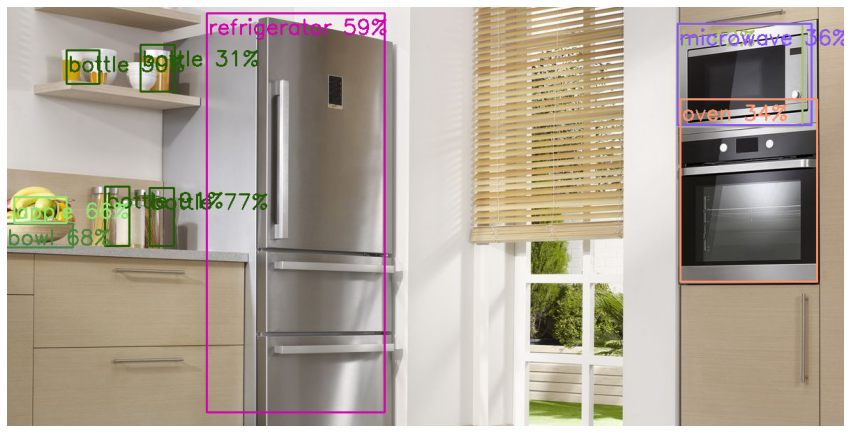

In [87]:
# loop over each of the detection
image_copy = image.copy()

for detection in output[0, 0, :, :]:
    # extract the confidence of the detection
    confidence = detection[2]

    # draw bounding boxes only if the detection confidence is above...
    # ... a certain threshold, else skip
    if confidence > 0.3:
        # get the class id
        class_id = detection[1]
        # map the class id to the class
        class_name = class_names[int(class_id) - 1]
        color = COLORS[int(class_id)]
        # get the bounding box upper left corner coordinates
        box_x_ul = detection[3] * image_width
        box_y_ul = detection[4] * image_height
        # get the bounding box bottom right corner coordinates
        box_x_br = detection[5] * image_width
        box_y_br = detection[6] * image_height
        # draw a rectangle around each detected object
        cv2.rectangle(
            image_copy,
            (int(box_x_ul), int(box_y_ul)),
            (int(box_x_br), int(box_y_br)),
            color,
            thickness=2,
        )
        # put the FPS text on top of the frame
        text = f"{class_name} {int(confidence * 100)}%"
        cv2.putText(
            image_copy,
            text,
            (int(box_x_ul + 2), int(box_y_ul + 30)),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            color,
            2,
        )

# Show image_copy with the detected objects
plt.imshow(image_copy)
plt.axis("off")

With this type of models onboard of a mobile robot, it would be able to detect the objects in its sourroundings and use this information during its operation. Awesome!

## Conclusion

Cool! You have experienced the trendy Deep Learning world a bit.

In this notebook you have learned:

- how look for different DL models that has been tested by the OpenCV community,

- how to load information related to the dataset at hand, as well as how to load the network weights (model) and configuration,

- how to do inference and visualize the results.


### **<span style="color:green"><b><i>Optional</i></b></span>**

Now that you know how to use OpenCV DNN you can challenge the model with other images or, even better, try another object detection network or a model targeted at a different task.

# Models
Depending on the use case, we can use a variety of models:

For real-time scenarios we could use YOLO based approaches. These models sacrifice accuracy for super low inference speeds. Depending on the backbone used we could get different results (ResNet, MobileNet, etc.)

If we don't mind slightly longer inference times we could use models like SSD, or more modern approaches like [FoveaBox](https://arxiv.org/pdf/1904.03797.pdf) or [CenterNet](https://openaccess.thecvf.com/content_ICCV_2019/papers/Duan_CenterNet_Keypoint_Triplets_for_Object_Detection_ICCV_2019_paper.pdf).

If we don't care about inference times and we just want to get good results we could use region-proposal based methods. These run in 2 or more phases, hence the longer inference times, [but they tend to be more accurate](https://openaccess.thecvf.com/content/CVPR2022W/VDU/papers/Cai_BigDetection_A_Large-Scale_Benchmark_for_Improved_Object_Detector_Pre-Training_CVPRW_2022_paper.pdf).

## Design
### Single pass vs Region proposal

Some of the earliest attempts at object detection made use of region proposal networks to identify *where* objects could be, and then made a second pass to make the final detections. This usually gives very accurate results at the cost of long inference times. 

On the other hand more modern approaches do a single pass (You Only Look Once, Single Shot Detection, etc.) to detect objects (bounding boxes, confidence, class, etc).

### Anchors
Some models, like the latests versions of YOLO or SSD use special, pre-computed boxes called anchors to help speed-up inference or improve predictions. This anchors aren't free though, as they must be designed specifically for every problem, or else lots of them should be generated.

On the other hand, some approaches like the first version of YOLO and modern models like FoveaBox don't use anchors and are able to generalize better.


## Other use cases

Some models allow us to estimate 3D bounding boxes, rotated bounding boxes, track objects in videos, etc.

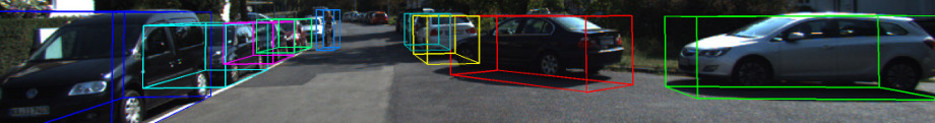

## References

<a name="myfootnote1">[1]</a>: LIU, Wei, et al. [Ssd: Single shot multibox detector](https://arxiv.org/abs/1512.02325). In European Conference on Computer Vision (ECCV). Springer, Cham, 2016. p. 21-37.